# Example adapted from Rosselini et.al 2024:

In [47]:
# importing the functions from our package
from Epistemic_CP.epistemic_cp import ECP_split, QuantileSplit
# quantile regression base model
from Epistemic_CP.utils import (GradientBoostingQuantileRegressor,
                                average_coverage,
                                average_interval_score_loss)
from Epistemic_CP.scores import QuantileScore

# base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing torch functions
import torch

# importing scipy stats
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [48]:
def generate_data(n, rng):
    x = np.cos(rng.beta(1.2, 0.8, n))

    # Função verdadeira para gerar y com maior variabilidade no centro de x
    def true_function(x):
        mean_y = np.sin(x**(-3))  
        std_y = x**4
        y = rng.normal(mean_y, std_y)  # Gerar y a partir de uma normal
        return y

    y = true_function(x)
    return pd.DataFrame({'x': x, 'y': y})

In [49]:
n_train = 200
n_calib = 200
n_test = 500
alpha = 0.1
regressor = GradientBoostingQuantileRegressor(alpha = alpha)

# fixing random generator and torch seeds
rng = np.random.default_rng(450)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

data_train = generate_data(n_train, rng)
data_calibration = generate_data(n_calib, rng)
data_test = generate_data(n_test, rng)

nGrid = 1000
X_grid = np.linspace(data_train["x"].min(), data_train["x"].max(), nGrid).reshape(-1, 1)

In [50]:
# fitting base model
X_train = data_train["x"].to_numpy().reshape(-1, 1)
y_train = data_train["y"].to_numpy()
regressor.fit(X_train, y_train)

GradientBoostingQuantileRegressor()

Defining EPICSCORE object:

In [51]:
# defining ECP object
ecp_obj = ECP_split(
    QuantileScore,
    regressor,
    alpha=alpha,
    is_fitted=True,
    base_model_type="Quantile",
)

# calibration data
X_calib = data_calibration["x"].to_numpy().reshape(-1, 1)
y_calib = data_calibration["y"].to_numpy()

Fitting EPICSCORE-MC Dropout

Fitting MDN model:  16%|█▋        | 330/2000 [00:06<00:33, 49.27it/s]

Early stopping in epoch 330 with best validation loss: 1.1937


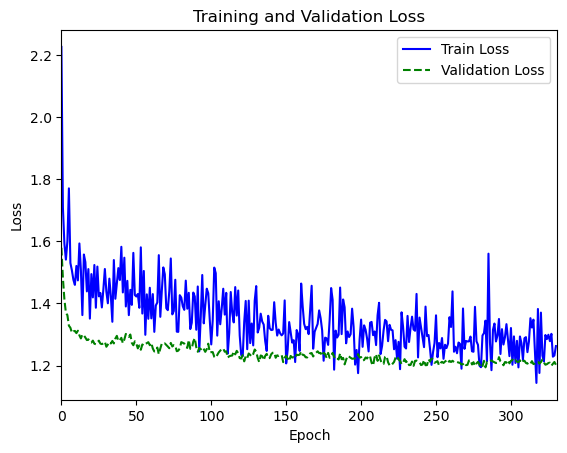

In [52]:
ecp_obj.fit(X_train, y_train)
ecp_obj.calib(
    X_calib,
    y_calib,
    num_components=3,
    dropout_rate=0.5,
    hidden_layers=[64, 64],
    patience=50,
    epochs=2000,
    scale=True,
    batch_size=15,
    normalize_y=True,
    verbose = 2,
)

# predicting PI for MDN
X_test = data_test["x"].to_numpy().reshape(-1, 1)
pred_ecp_mdn = ecp_obj.predict(X_test)
grid_ecp_mdn = ecp_obj.predict(X_grid)

# computing marginal coverage
y_test = data_test["y"].to_numpy()
ecp_mdn_marginal_coverage = average_coverage(pred_ecp_mdn[:, 1], pred_ecp_mdn[:, 0], y_test)
ecp_mdn_aisl = average_interval_score_loss(pred_ecp_mdn[:, 1], pred_ecp_mdn[:, 0], y_test, alpha = alpha)

Fitting EPICSCORE-Variational GP:

Fitting GP model:  21%|██▏       | 107/500 [00:08<00:30, 12.97it/s]

Early stopping in epoch 107 with best validation loss:  1.4504


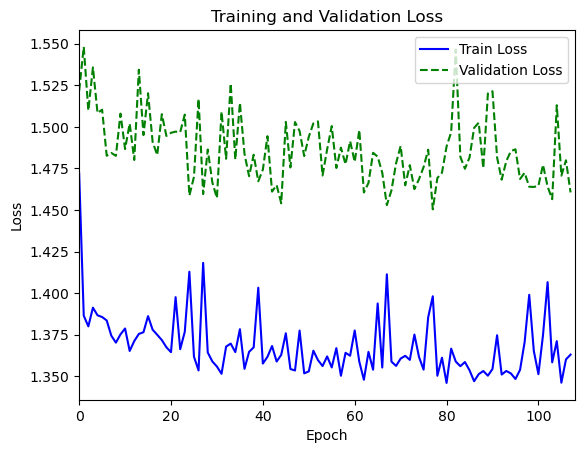

In [53]:
ecp_obj.calib(
    X_calib,
    y_calib,
    epistemic_model="GP_variational",
    scale=True,
    normalize_y=True,
    num_inducing_points=10,
    n_epoch=500,
    batch_size=15,
    verbose = 2,
)

X_test = data_test["x"].to_numpy().reshape(-1, 1)
pred_ecp_gp = ecp_obj.predict(X_test)
grid_ecp_gp = ecp_obj.predict(X_grid)

# computing marginal coverage
y_test = data_test["y"].to_numpy()
ecp_gp_marginal_coverage = average_coverage(pred_ecp_gp[:, 1], pred_ecp_gp[:, 0], y_test)
ecp_gp_aisl = average_interval_score_loss(pred_ecp_gp[:, 1], pred_ecp_gp[:, 0], y_test, alpha = alpha)

Fitting EPISCORE-BART:

In [54]:
ecp_obj.fit(X_train, y_train)
ecp_obj.calib(
    X_calib,
    y_calib,
    epistemic_model="BART",
    m=100,
    var="heteroscedastic",
    type = "normal",
    normalize_y = "True",
    progress = False,
)
# predicting PI for BART
X_test = data_test["x"].to_numpy().reshape(-1, 1)
pred_ecp_bart = ecp_obj.predict(X_test)
grid_ecp_bart = ecp_obj.predict(X_grid)

# computing marginal coverage
y_test = data_test["y"].to_numpy()
ecp_bart_marginal_coverage = average_coverage(pred_ecp_bart[:, 1], pred_ecp_bart[:, 0], y_test)
ecp_bart_aisl = average_interval_score_loss(pred_ecp_bart[:, 1], pred_ecp_bart[:, 0], y_test, alpha = alpha)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [w, y_pred]
Sampling: [w, y_pred]
Sampling: [w, y_pred]


Fitting CQR for comparisson:

In [55]:
cqr_obj = QuantileSplit(regressor,
                        alpha = alpha,
                        is_fitted = True)
cqr_obj.fit(X_train, y_train)
cqr_obj.calibrate(X_calib, y_calib)

X_test = data_test["x"].to_numpy().reshape(-1, 1)
pred_cqr = cqr_obj.predict(X_test)
grid_cqr = cqr_obj.predict(X_grid)

# computing marginal coverage
y_test = data_test["y"].to_numpy()
cqr_marginal_coverage = average_coverage(pred_cqr[:, 1], pred_cqr[:, 0], y_test)
cqr_aisl = average_interval_score_loss(pred_cqr[:, 1], pred_cqr[:, 0], y_test, alpha = alpha)

Printing marginal coverage and AISL:

In [56]:
print("EPICSCORE-MC Dropout:")
print(f"Marginal Coverage: {ecp_mdn_marginal_coverage}")
print(f"AISL: {ecp_mdn_aisl}\n")

print("EPICSCORE-Variational GP:")
print(f"Marginal Coverage: {ecp_gp_marginal_coverage}")
print(f"AISL: {ecp_gp_aisl}\n")

print("EPICSCORE-BART:")
print(f"Marginal Coverage: {ecp_bart_marginal_coverage}")
print(f"AISL: {ecp_bart_aisl}\n")

print("CQR:")
print(f"Marginal Coverage: {cqr_marginal_coverage}")
print(f"AISL: {cqr_aisl}")

EPICSCORE-MC Dropout:
Marginal Coverage: 0.898
AISL: 2.2616200396354844

EPICSCORE-Variational GP:
Marginal Coverage: 0.904
AISL: 2.4822373994673907

EPICSCORE-BART:
Marginal Coverage: 0.882
AISL: 2.2104824102562755

CQR:
Marginal Coverage: 0.888
AISL: 2.2537841002969445


Plotting:

/tmp/ipykernel_13773/1108933241.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 0].legend()
/tmp/ipykernel_13773/1108933241.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 1].legend()
/tmp/ipykernel_13773/1108933241.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend()
/tmp/ipykernel_13773/1108933241.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 1].legend()


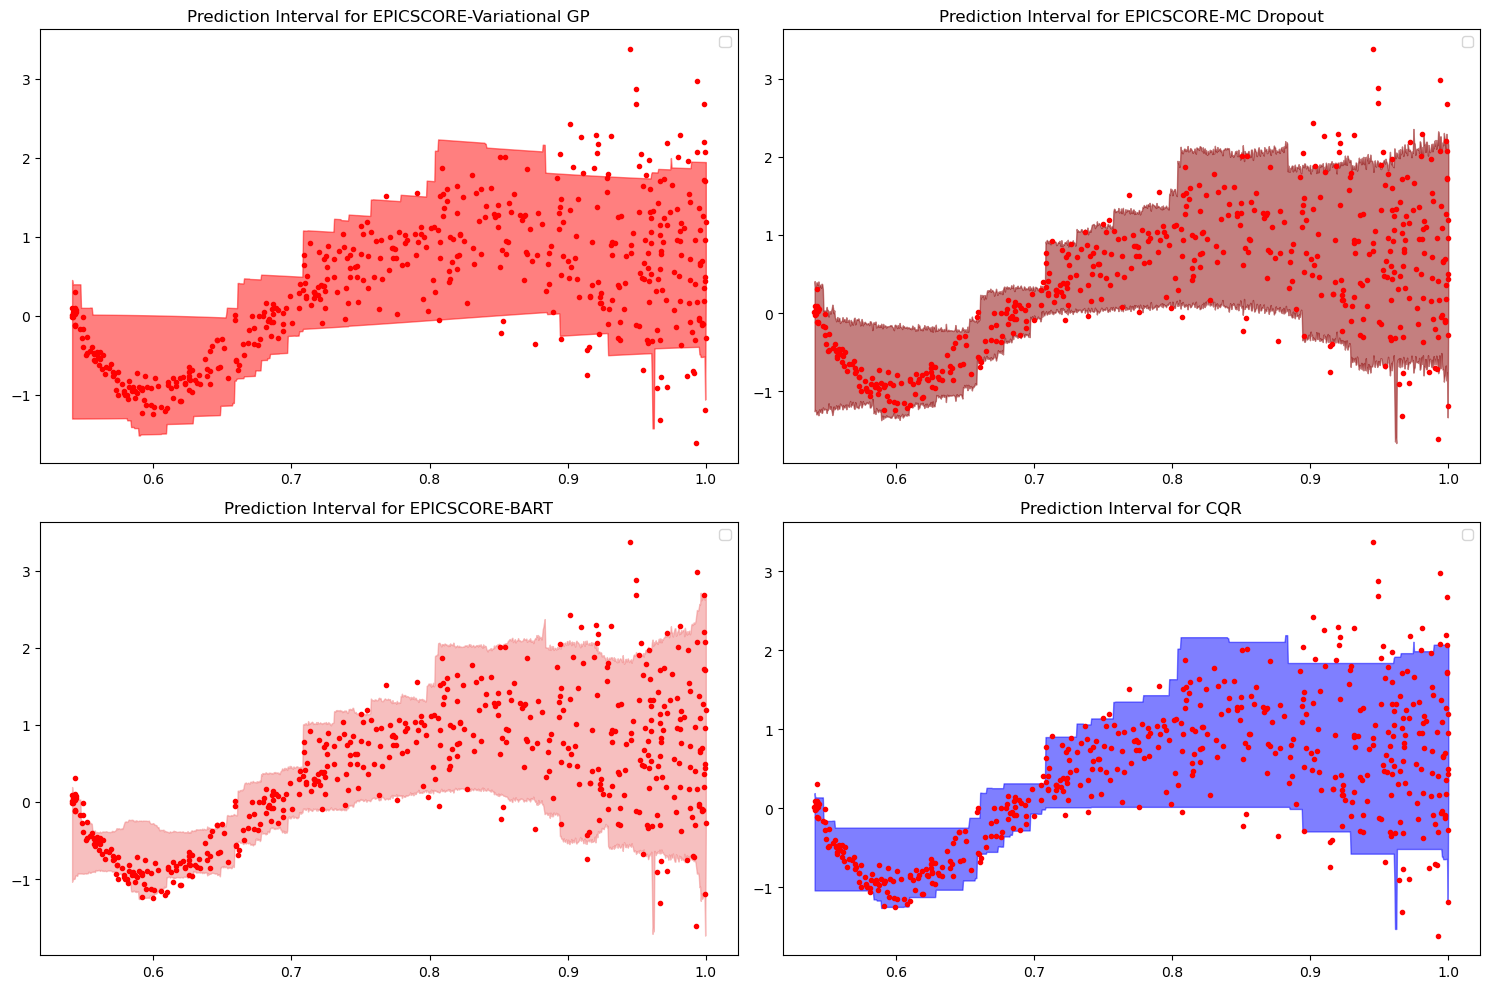

In [57]:
# Adjusting the layout to have 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot for grid_ecp_gp
axs[0, 0].fill_between(X_grid.flatten(), grid_ecp_gp[:, 0], grid_ecp_gp[:, 1], color='red', alpha=0.5)
axs[0, 0].plot(data_test["x"], y_test, 'r.')
axs[0, 0].set_title('Prediction Interval for EPICSCORE-Variational GP')
axs[0, 0].legend()

# Plot for grid_ecp_mdn
axs[0, 1].fill_between(X_grid.flatten(),
                       grid_ecp_mdn[:, 0], 
                       grid_ecp_mdn[:, 1], 
                       color='darkred',
                       alpha=0.5)
axs[0, 1].plot(data_test["x"], y_test, 'r.')
axs[0, 1].set_title('Prediction Interval for EPICSCORE-MC Dropout')
axs[0, 1].legend()

# Plot for grid_ecp_bart
axs[1, 0].fill_between(X_grid.flatten(), grid_ecp_bart[:, 0], grid_ecp_bart[:, 1], color='lightcoral', alpha=0.5)
axs[1, 0].plot(data_test["x"], y_test, 'r.')
axs[1, 0].set_title('Prediction Interval for EPICSCORE-BART')
axs[1, 0].legend()

# Plot for grid_cqr
axs[1, 1].fill_between(X_grid.flatten(), grid_cqr[:, 0], grid_cqr[:, 1], color='blue', alpha=0.5)
axs[1, 1].plot(data_test["x"], y_test, 'r.')
axs[1, 1].set_title('Prediction Interval for CQR')
axs[1, 1].legend()

plt.tight_layout()
plt.show()